# Movie Recommendation System using User Ratings

* In this project, I am creating a movie recmmender System.
* I will use kNN and Cosine Similarity
* Content-based recommendation system is to recommend an item based on a comparison between the content of the items and a user profile. Content based approaches use additional information about users and/or items.

### Importing Datasets
Below data has been taken from MovieLens 20M Dataset
*Source: https://www.kaggle.com/grouplens/movielens-20m-dataset?select=movie.csv*

Context - The datasets describe ratings and free-text tagging activities from MovieLens, a movie recommendation service. It contains 20000263 ratings and 465564 tag applications across 27278 movies. These data were created by 138493 users between January 09, 1995 and March 31, 2015. This dataset was generated on October 17, 2016.


In [ ]:
# importing basic libraries
import pandas as pd
import numpy as np

In [ ]:
# usecols allows us to select our choice of features
movies_df=pd.read_csv('movies.csv', usecols=['movieId','title'], dtype={'movieId':'int32','title':'str'})
movies_df.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [ ]:
ratings_df=pd.read_csv('ratings.csv',
    usecols=['userId', 'movieId', 'rating','timestamp'],dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
#checkinng for NaN values
movies_df.isnull().sum()

movieId    0
title      0
dtype: int64

In [ ]:
ratings_df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [ ]:
print("Movies:",movies_df.shape)
print("Ratings:",ratings_df.shape)

Movies: (9742, 2)
Ratings: (100836, 4)


### Merging the imported Datasets for Analysis

In [ ]:
#movies_df.info()
#ratings_df.info()
movies_merged_df=movies_df.merge(ratings_df, on='movieId')
movies_merged_df.head()

,movieId,title,userId,rating,timestamp
0,1,Toy Story (1995),1,4.0,964982703
1,1,Toy Story (1995),5,4.0,847434962
2,1,Toy Story (1995),7,4.5,1106635946
3,1,Toy Story (1995),15,2.5,1510577970
4,1,Toy Story (1995),17,4.5,1305696483


In [ ]:
movies_merged_df=movies_merged_df.dropna(axis = 0, subset = ['title'])
movies_merged_df.head()

,movieId,title,userId,rating,timestamp
0,1,Toy Story (1995),1,4.0,964982703
1,1,Toy Story (1995),5,4.0,847434962
2,1,Toy Story (1995),7,4.5,1106635946
3,1,Toy Story (1995),15,2.5,1510577970
4,1,Toy Story (1995),17,4.5,1305696483


In [ ]:
movies_average_rating=movies_merged_df.groupby('title')['rating'].mean().sort_values(ascending=False).reset_index().rename(columns={'rating':'Average Rating'})
movies_average_rating.head()

,title,Average Rating
0,Karlson Returns (1970),5.0
1,Winter in Prostokvashino (1984),5.0
2,My Love (2006),5.0
3,Sorority House Massacre II (1990),5.0
4,Winnie the Pooh and the Day of Concern (1972),5.0


In [ ]:
movies_rating_count=movies_merged_df.groupby('title')['rating'].count().sort_values(ascending=True).reset_index().rename(columns={'rating':'Rating Count'}) #ascending=False
movies_rating_count_avg=movies_rating_count.merge(movies_average_rating, on='title')
movies_rating_count_avg.head()

,title,Rating Count,Average Rating
0,'71 (2014),1,4.0
1,Latter Days (2003),1,3.5
2,"Late Shift, The (1996)",1,2.5
3,Late Night with Conan O'Brien: The Best of Tri...,1,2.0
4,Late Night Shopping (2001),1,4.5


**Observation**- 
* Many movies have a pefrect 5 star average rating on a dataset of almost 100k user ratings. This suggests the existence of outliers which we need to further confirm with visualization.
* The presence of single ratings for several movies suggests that I set a threshold value of ratings to produce valuable recommendations

### Data Visualization
I will focus on creating plots to prove/disprove the observations and analyze the trends in the data (if any). I will stick to seaborn and matplotlib for this project.

In [ ]:
#importing visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale = 1)
plt.rcParams["axes.grid"] = False
plt.style.use('dark_background')
%matplotlib inline

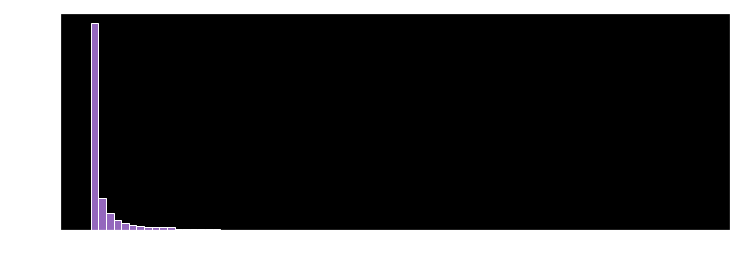

In [ ]:
plt.figure(figsize=(12,4))
plt.hist(movies_rating_count_avg['Rating Count'],bins=80,color='tab:purple')
plt.ylabel('Ratings Count(Scaled)', fontsize=16)
plt.savefig('ratingcounthist.jpg')

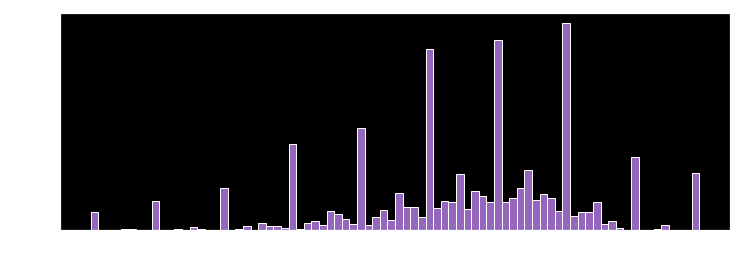

In [ ]:
plt.figure(figsize=(12,4))
plt.hist(movies_rating_count_avg['Average Rating'],bins=80,color='tab:purple')
plt.ylabel('Average Rating',fontsize=16)
plt.savefig('avgratinghist.jpg')

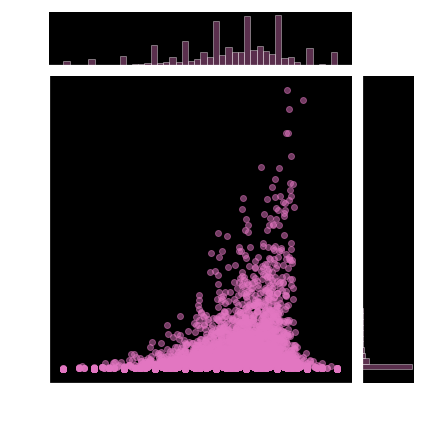

In [ ]:

plot=sns.jointplot(x='Average Rating',y='Rating Count',data=movies_rating_count_avg,alpha=0.5, color='tab:pink')
plot.savefig('joinplot.jpg')

**Analysis**-
* Plot #1 confirms our observations of a high volume of movies with low ratings count. Apart from setting a threshold, we can also use quantiles at some higher percentile for this usecase.
* Histogram #2 showcases the distribution function of the Average Rating values.
* Joinplot beautifully illustrates that there is only a subset of values with higher rating that have considerable amount of ratings.

### Eliminating Outliers

In [ ]:
rating_with_RatingCount = movies_merged_df.merge(movies_rating_count, left_on = 'title', right_on = 'title', how = 'left')
rating_with_RatingCount.head()

,movieId,title,userId,rating,timestamp,Rating Count
0,1,Toy Story (1995),1,4.0,964982703,215
1,1,Toy Story (1995),5,4.0,847434962,215
2,1,Toy Story (1995),7,4.5,1106635946,215
3,1,Toy Story (1995),15,2.5,1510577970,215
4,1,Toy Story (1995),17,4.5,1305696483,215


In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(rating_with_RatingCount['Rating Count'].describe())

count   100836.000
mean        58.759
std         61.965
min          1.000
25%         13.000
50%         39.000
75%         84.000
max        329.000
Name: Rating Count, dtype: float64


In [ ]:
popularity_threshold = 50
popular_movies= rating_with_RatingCount[rating_with_RatingCount['Rating Count']>=popularity_threshold]
popular_movies.head()
#popular_movies.shape

,movieId,title,userId,rating,timestamp,Rating Count
0,1,Toy Story (1995),1,4.000,964982703,215
1,1,Toy Story (1995),5,4.000,847434962,215
2,1,Toy Story (1995),7,4.500,1106635946,215
3,1,Toy Story (1995),15,2.500,1510577970,215
4,1,Toy Story (1995),17,4.500,1305696483,215


### Pivotting title as indices & userId as columns

In [ ]:
import os
movie_features_df=popular_movies.pivot_table(index='title',columns='userId',values='rating').fillna(0)
movie_features_df.head()
movie_features_df.to_excel('output.xlsx')

### Creating kNN Model

In [ ]:
from scipy.sparse import csr_matrix
movie_features_df_matrix = csr_matrix(movie_features_df.values)

In [ ]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(movie_features_df_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
movie_features_df.shape

(450, 606)

In [ ]:
query_index = np.random.choice(movie_features_df.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(movie_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)
query_index=196

193


In [ ]:
movie_features_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
10 Things I Hate About You (1999),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,3.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000
12 Angry Men (1957),0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,...,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2001: A Space Odyssey (1968),0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,...,0.000,0.000,5.000,0.000,0.000,5.000,0.000,3.000,0.000,4.500
28 Days Later (2002),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.500,0.000,5.000
300 (2007),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,...,0.000,0.000,0.000,0.000,3.000,0.000,0.000,5.000,0.000,4.000


In [ ]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(movie_features_df.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, movie_features_df.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Harry Potter and the Order of the Phoenix (2007):

1: Harry Potter and the Half-Blood Prince (2009), with distance of 0.2346513867378235:
2: Harry Potter and the Order of the Phoenix (2007), with distance of 0.3396233320236206:
3: Harry Potter and the Goblet of Fire (2005), with distance of 0.4170845150947571:
4: Harry Potter and the Prisoner of Azkaban (2004), with distance of 0.4499547481536865:
5: Harry Potter and the Chamber of Secrets (2002), with distance of 0.4506162405014038:


#Summary#
##We've Performed the following topics in Porject:##

A typical problem statement for machine learning

Importing Datasets

Exploring a dataset for machine learning

Data Visualization

KNN model using Scikit-learn